In [1]:
%cd ..

/Users/chan/boostcamp-project/level2-nlp-generationfornlp-nlp-06-lv3


/Users/chan/boostcamp-project/level2-nlp-generationfornlp-nlp-06-lv3/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from langchain.output_parsers import OutputFixingParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from tqdm import tqdm

from prompts import load_template
from utils import create_experiment_file_name

In [ ]:
DATA_DIR = "data"
RESULT_DIR = "experiments"
TARGET_DATA = "train_v2.0.1.csv"
EXP_VERSION = "v0.0.0"  # 컨벤션에 따라 새롭게 실험할 경우 버저닝 정보를 기록해주세요.

dataset = pd.read_csv(os.path.join(DATA_DIR, TARGET_DATA))
dataset.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"['ㄱ, ㄴ', 'ㄱ, ㄷ', 'ㄴ, ㄹ', 'ㄷ, ㄹ']",2,ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 ...
1,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"['이곳에 대장도감을 설치하여 재조대장경을 만들었다.', '지눌이 이곳에서 수선사 ...",4,NaN
2,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"['살수에서 수의 군대를 물리쳤다 .', '김춘추 의 신라 왕위 계승을 지원하였다 ...",2,NaN
3,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"['사창제를 실시하였다 .', '대전회통을 편찬하였다 .', '비변사의 기능을 강화...",3,NaN
4,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"['나 당연합군의 공격으로 멸망하였다 .', '9주 5소경의 지방 행정 구역을 두었...",3,NaN


In [ ]:
# note: dataset.head() 동작으로 칼럼 명 정보륾 확인하고 동작해주세요.
PARAGRAPH = "paragraph"
QUESTION = "question"
CHOICES = "choices"
ANSWER = "answer"
QUESTION_PLUS = "question_plus"

.env 파일에 다음과 같은 형식으로 platform.openai.com에서 발급받은 토큰을 넣어주세요

```bash
HF_TOKEN={your_hf_token}    # 기존 .env
OPENAI_APIT_KEY={your_openai_token} # 추가할 토큰
```


In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
prompt = PromptTemplate.from_template(
    template=load_template(file_name="solving_strategies.txt", template_type="data_classification")
)

output_parser = JsonOutputParser()

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini", temperature=0, max_tokens=None, timeout=None, max_retries=2, api_key=OPENAI_API_KEY
)
fixing_parser = OutputFixingParser.from_llm(parser=output_parser, llm=llm)

chain = prompt | llm | fixing_parser

In [ ]:
def classify_problem(data: pd.Series) -> tuple[str, str]:
    """프롬프트에 따라 LLM이 문제 데이터를 분류하고 결과를 문자열로 반환하는 함수

    Args:
        data (pd.Series): 제공된 데이터셋의 한 행(row), 문제 하나

    Returns:
        tuple[str, str]: 문제가 분류된 카테고리와 도출된 이유
    """
    response = chain.invoke({"paragraph": data[PARAGRAPH], "choices": data[CHOICES], "question": data[QUESTION]})
    category, reason = response["category"], response["thinking"]
    return category, reason


# test
test_data = dataset.iloc[20]
test_results = classify_problem(test_data)
print(f"테스트 데이터: {test_data}, 테스트 결과: {test_results}")

테스트 데이터: id                                          generation-for-nlp-451
paragraph        임진왜란 이후에 우의 정 유성룡도 역시 미곡을 거두는 것이 편리하다고 주장하였으나,...
question                                    (가)에 대한 설명으로 옳지 않은 것은?
choices          ['장시의 확대에 기여하였다 .', '지주에게 결작을 부과하였다 .', '공납의 폐...
answer                                                           2
question_plus                                                  NaN
Name: 20, dtype: object, 테스트 결과: ('연결형 추론', '문제와 지문에서 (가)에 대한 설명을 파악하기 위해서는 조선 시대의 역사적 배경과 관련된 지식이 필요합니다. 선택지들은 (가)의 시행 목적과 결과에 대한 이해를 요구하므로, 역사적 맥락을 연결하여 분석해야 합니다. 따라서, 연결형 추론 카테고리에 속합니다.')


In [ ]:
tqdm.pandas()

In [ ]:
mpl.rcParams["font.family"] = "AppleGothic"
mpl.rcParams["axes.unicode_minus"] = False

# 전체 데이터에 대해 분류 진행


In [ ]:
dataset[["category", "reason"]] = dataset.progress_apply(lambda x: pd.Series(classify_problem(x)), axis=1)
# 약 90분 소요

100%|██████████| 2029/2029 [1:18:02<00:00,  2.31s/it]


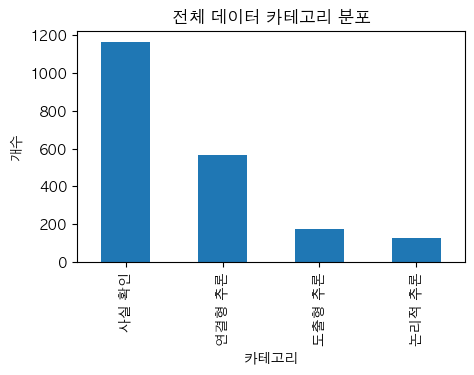

In [ ]:
category_counts = dataset["category"].value_counts()

plt.figure(figsize=(5, 3))
category_counts.plot(kind="bar")
plt.title("전체 데이터 카테고리 분포")
plt.xlabel("카테고리")
plt.ylabel("개수")
plt.savefig(f"eda/images/fig_{EXP_VERSION}.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
result_file_name = create_experiment_file_name(target_file=TARGET_DATA, version=EXP_VERSION)
result_file_path = os.path.join(DATA_DIR, RESULT_DIR, result_file_name)
result_file_path

'data/experiments/train_exp_v0.0.0.csv'

In [ ]:
dataset.to_csv(result_file_path, index=False)